---
IntAct

---


https://www.ebi.ac.uk/intact/

- Format: PSI-MI TAB 2.7 http://psicquic.github.io/MITAB27Format.html

Codes for the columns:
- 9-10. NCBI Taxonomy https://www.ncbi.nlm.nih.gov/Taxonomy/CommonTree/wwwcmt.cgi

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# from Bio import SeqIO
import requests
import urllib
import re
from io import StringIO
# import shutil
# import urllib.request as request
# from contextlib import closing
import gzip
from ftplib import FTP
import pickle as pkl
import math

from toolbox import *

%matplotlib inline

In [2]:
cfg = load_cfg()

logVersions = load_LogVersions()

---
**For figures**

In [4]:
from figures_toolbox import *

In [5]:
mpl.rcParams.update(mpl.rcParamsDefault)

sns.set(
    context='paper',
    style='ticks',
)

%matplotlib inline

In [6]:
mpl.rcParams.update(performancePlot_style)

# Download data

In [5]:
doDownload = False

In [4]:
# Check timestamp

ftp = FTP('ftp.ebi.ac.uk')
ftp.login()
ftp.cwd('/pub/databases/intact/current/psimitab/')

intact_filename = 'intact.txt'
versionIntAct = ftp.voidcmd("MDTM " + intact_filename)[4:12]
print("Timestamp: {}".format(versionIntAct))
ftp.quit()

Timestamp: 20211015


'221 Goodbye.'

In [6]:
if doDownload:
    ftp = FTP('ftp.ebi.ac.uk')
    ftp.login()
    ftp.cwd('/pub/databases/intact/current/psimitab/')

    intact_filename = 'intact.txt'
    # Collect timestamp
    versionIntAct = ftp.voidcmd("MDTM " + intact_filename)[4:12]
    print("Timestamp: {}".format(versionIntAct))

    localFile = os.path.join(cfg['rawDataIntact'], "intact_v{}.txt".format(versionIntAct))
    print("Download location: {}".format(localFile))

    with open(localFile, 'wb') as f:
        ftp.retrbinary('RETR ' + intact_filename, f.write, 1024)

    ftp.quit()

Timestamp: 20211015
Download location: /rds/user/ll582/hpc-work/PPIdata/rawData/IntAct/intact_v20211015.txt


In [7]:
if doDownload:
#     logVersions['IntAct'] = dict()
    logVersions['IntAct']['rawData'] = versionIntAct

    dump_LogVersions(logVersions)

# Preprocessing

In [8]:
dfIntAct = pd.read_csv(os.path.join(cfg['rawDataIntact'],
                                    "intact_v{}.txt".format(logVersions['IntAct']['rawData'])), 
                       sep="\t")
glance(dfIntAct)

DataFrame: 1,155,104 rows 	 42 columns


,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Checksum(s) interactor A,Checksum(s) interactor B,Interaction Checksum(s),Negative,Feature(s) interactor A,Feature(s) interactor B,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B
0,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,rogid:RA73eMbCn6F7MD0ItxF/V7QbjqM9606,intact-crc:F4234557A3B54840|rigid:n+UcEH4PPLkF...,False,binding-associated region:626-695(MINT-376295),binding-associated region:1063-1070(MINT-376288),-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0078""(nucleotide sequence identific..."
1,uniprotkb:P49418,intact:EBI-7121639,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:MINT-8094608,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:vrparrvlw(display_short)|psi-mi:EBI-712...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,rogid:lPy6gBhpgvyGSYgOqeHbjcqBtMQ-2,intact-crc:880913D9000BF26E|rigid:iRObbQsaUeX0...,False,binding-associated region:626-695(MINT-8094602),-,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0083""(peptide synthesis)"
2,uniprotkb:P49418,intact:EBI-7121654,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:MINT-8094645,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:hrpvrraap(display_short)|psi-mi:EBI-712...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,rogid:GsDnsVmAo8ZZoKTZ4/uDb2x+h3c-2,intact-crc:B68245E1F0508124|rigid:SlinPP5vIczF...,False,binding-associated region:626-695(MINT-8094630),-,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0083""(peptide synthesis)"
3,uniprotkb:P49418,intact:EBI-7121715,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:MINT-8094663,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:vrptraada(display_short)|psi-mi:EBI-712...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,rogid:M+f6GE3SQXrMBiIVttW1MKhz3M0-2,intact-crc:8F7F46DF027DF34E|rigid:uiWbDe6gaj1X...,False,binding-associated region:626-695(MINT-8094654),-,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0083""(peptide synthesis)"
4,intact:EBI-7121765,uniprotkb:P49418,intact:MINT-8094691,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,psi-mi:xrprrghal(display_short)|psi-mi:EBI-712...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...",...,rogid:cilZXZ3YLDI1s7n8WNRyUE6EnJQ-2,rogid:vrgVrVoYr45cUe4X6L/zBAE1RtU9606,intact-crc:2EF43A66D9B2D428|rigid:/ki1zA46M4Q+...,False,-,binding-associated region:626-695(MINT-8094680),-,-,"psi-mi:""MI:0083""(peptide synthesis)","psi-mi:""MI:0078""(nucleotide sequence identific..."


In [9]:
dfIntAct.iloc[0,:]

#ID(s) interactor A                                                     uniprotkb:P49418
ID(s) interactor B                                                      uniprotkb:O43426
Alt. ID(s) interactor A                intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...
Alt. ID(s) interactor B                intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...
Alias(es) interactor A                 psi-mi:amph_human(display_long)|uniprotkb:AMPH...
Alias(es) interactor B                 psi-mi:synj1_human(display_long)|uniprotkb:SYN...
Interaction detection method(s)                          psi-mi:"MI:0084"(phage display)
Publication 1st author(s)                                           Cestra et al. (1999)
Publication Identifier(s)                              pubmed:10542231|mint:MINT-5211933
Taxid interactor A                            taxid:9606(human)|taxid:9606(Homo sapiens)
Taxid interactor B                            taxid:9606(human)|taxid:9606(Homo sapiens)
Interaction type(s)  

## Filter 1: human PPIs with UniProtKB IDs

**Parse and filter UniProtKB IDs**

In [10]:
dfIntAct["All IDs interactor A"] = dfIntAct["#ID(s) interactor A"] + "|" + dfIntAct["Alt. ID(s) interactor A"]
dfIntAct["All IDs interactor B"] = dfIntAct["ID(s) interactor B"] + "|" + dfIntAct["Alt. ID(s) interactor B"]

*Extract UniProtKB ID*

In [11]:
regex1 = re.compile(r"(?<=uniprotkb:)[\w]+")

dfIntAct.loc[:,'uniprotkb_IDs_A'] = ['|'.join(m) for m in (re.findall(regex1, line) for line in dfIntAct.loc[:,"All IDs interactor A"])]
dfIntAct.loc[:,'uniprotkb_IDs_B'] = ['|'.join(m) for m in (re.findall(regex1, line) for line in dfIntAct.loc[:,"All IDs interactor B"])]

dfIntAct.loc[:,'first_uniprotkb_IDs_A'] = [m.group() if m else '' for m in (regex1.search(line) for line in dfIntAct.loc[:,"All IDs interactor A"])]
dfIntAct.loc[:,'first_uniprotkb_IDs_B'] = [m.group() if m else '' for m in (regex1.search(line) for line in dfIntAct.loc[:,"All IDs interactor B"])]

glance(dfIntAct)

DataFrame: 1,155,104 rows 	 48 columns


,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B,All IDs interactor A,All IDs interactor B,uniprotkb_IDs_A,uniprotkb_IDs_B,first_uniprotkb_IDs_A,first_uniprotkb_IDs_B
0,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0078""(nucleotide sequence identific...",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
1,uniprotkb:P49418,intact:EBI-7121639,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:MINT-8094608,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:vrparrvlw(display_short)|psi-mi:EBI-712...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,intact:EBI-7121639|intact:MINT-8094608,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,,P49418,
2,uniprotkb:P49418,intact:EBI-7121654,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:MINT-8094645,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:hrpvrraap(display_short)|psi-mi:EBI-712...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,intact:EBI-7121654|intact:MINT-8094645,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,,P49418,
3,uniprotkb:P49418,intact:EBI-7121715,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:MINT-8094663,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:vrptraada(display_short)|psi-mi:EBI-712...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,intact:EBI-7121715|intact:MINT-8094663,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,,P49418,
4,intact:EBI-7121765,uniprotkb:P49418,intact:MINT-8094691,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,psi-mi:xrprrghal(display_short)|psi-mi:EBI-712...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,"taxid:-2(chemical synthesis)|taxid:-2(""Chemica...",...,-,-,"psi-mi:""MI:0083""(peptide synthesis)","psi-mi:""MI:0078""(nucleotide sequence identific...",intact:EBI-7121765|intact:MINT-8094691,uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,,P49418


*Remove interactions with missing IDs*

In [12]:
foo = (dfIntAct.first_uniprotkb_IDs_A == '')|(dfIntAct.first_uniprotkb_IDs_B == '')

print('{:,}/{:,} ({:.1%}) of the interactions have at least one interactor without uniprotKB ID'.format(
    len(dfIntAct.loc[foo]),
    len(dfIntAct),
    len(dfIntAct.loc[foo])/len(dfIntAct)

))

88,897/1,155,104 (7.7%) of the interactions have at least one interactor without uniprotKB ID


In [13]:
dfIntAct_1 = dfIntAct.loc[
    (dfIntAct.first_uniprotkb_IDs_A != '')&(dfIntAct.first_uniprotkb_IDs_B != '')
]
glance(dfIntAct_1)

DataFrame: 1,066,207 rows 	 48 columns


,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B,All IDs interactor A,All IDs interactor B,uniprotkb_IDs_A,uniprotkb_IDs_B,first_uniprotkb_IDs_A,first_uniprotkb_IDs_B
0,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0078""(nucleotide sequence identific...",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
28,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
29,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
30,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
31,uniprotkb:Q99961,uniprotkb:O43426,intact:EBI-697911|uniprotkb:Q99668|uniprotkb:B...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:sh3g1_human(display_long)|uniprotkb:End...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:Q99961|intact:EBI-697911|uniprotkb:Q...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,Q99961|Q99668|B4DRA1|E7EVZ4|M0QZV5,O43426|O43425|O94984|Q4KMR1,Q99961,O43426


---
**Human-human interactions**

In [14]:
# Sanity check
foo = list(set(dfIntAct_1['Taxid interactor A'].tolist() + dfIntAct_1['Taxid interactor A'].tolist()))
bar = [s for s in foo if ":9606" in s]
print(bar)
assert len(bar) == 1

['taxid:9606(human)|taxid:9606(Homo sapiens)']


In [15]:
foo = 'taxid:9606(human)|taxid:9606(Homo sapiens)'
dfIntAct_2 = dfIntAct_1.loc[
    (dfIntAct_1['Taxid interactor A'] == foo)&(dfIntAct_1['Taxid interactor B'] == foo)
]
glance(dfIntAct_2)

DataFrame: 574,531 rows 	 48 columns


,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B,All IDs interactor A,All IDs interactor B,uniprotkb_IDs_A,uniprotkb_IDs_B,first_uniprotkb_IDs_A,first_uniprotkb_IDs_B
0,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0078""(nucleotide sequence identific...",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
28,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
29,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
30,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
31,uniprotkb:Q99961,uniprotkb:O43426,intact:EBI-697911|uniprotkb:Q99668|uniprotkb:B...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:sh3g1_human(display_long)|uniprotkb:End...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:Q99961|intact:EBI-697911|uniprotkb:Q...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,Q99961|Q99668|B4DRA1|E7EVZ4|M0QZV5,O43426|O43425|O94984|Q4KMR1,Q99961,O43426


---
**protein-protein interactions**

In [16]:
print(dfIntAct_2.groupby(by="Type(s) interactor A").size().sort_values(ascending=False))
print(dfIntAct_2.groupby(by="Type(s) interactor B").size().sort_values(ascending=False))

Type(s) interactor A
psi-mi:"MI:0326"(protein)         574494
psi-mi:"MI:1304"(molecule set)        36
psi-mi:"MI:0327"(peptide)              1
dtype: int64
Type(s) interactor B
psi-mi:"MI:0326"(protein)         574396
psi-mi:"MI:1304"(molecule set)       135
dtype: int64


In [17]:
foo = 'psi-mi:"MI:0326"(protein)'
dfIntAct_3 = dfIntAct_2.loc[
    (dfIntAct['Type(s) interactor A'] == foo)&(dfIntAct['Type(s) interactor B'] == foo)
]
glance(dfIntAct_3)

DataFrame: 574,359 rows 	 48 columns


,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Stoichiometry(s) interactor A,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B,All IDs interactor A,All IDs interactor B,uniprotkb_IDs_A,uniprotkb_IDs_B,first_uniprotkb_IDs_A,first_uniprotkb_IDs_B
0,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0078""(nucleotide sequence identific...",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
28,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
29,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
30,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426
31,uniprotkb:Q99961,uniprotkb:O43426,intact:EBI-697911|uniprotkb:Q99668|uniprotkb:B...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:sh3g1_human(display_long)|uniprotkb:End...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:Q99961|intact:EBI-697911|uniprotkb:Q...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,Q99961|Q99668|B4DRA1|E7EVZ4|M0QZV5,O43426|O43425|O94984|Q4KMR1,Q99961,O43426


---
**Confidence score** 

Details of intact mi-score: https://www.ebi.ac.uk/intact/pages/faq/faq.xhtml#9

*Pull names of scores*

In [18]:
reConfScore = re.compile(r"(?<=\|)[-\s\w]+(?=:)")

confScoreNames =[val for sublist in [reConfScore.findall("|" + line) for line in dfIntAct_3["Confidence value(s)"]] for val in sublist]

set(confScoreNames)

{'author score',
 'author-confidence',
 'intact-miscore',
 'replication-based confidence'}

*Pull intact-miscore values*

In [19]:
reIntactMiscore = re.compile(r"(?<=intact-miscore:)[\d.]+")

dfIntAct_3.loc[:,'intact-miscore'] = [m.group() if m else 'NA' for m in (reIntactMiscore.search(line) for line in dfIntAct_3["Confidence value(s)"])]

# Sanity check
assert len(dfIntAct_3.loc[dfIntAct_3['intact-miscore'] == 'NA']) == 0

dfIntAct_3.loc[:,'intact-miscore'] = pd.to_numeric(dfIntAct_3['intact-miscore'])
dfIntAct_3['intact-miscore'][:5]

/home/ll582/.conda/envs/PPI/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/ll582/.conda/envs/PPI/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0     0.56
28    0.56
29    0.56
30    0.56
31    0.44
Name: intact-miscore, dtype: float64

---
**Sanity checks**

In [20]:
assert len(dfIntAct_3.loc[dfIntAct_3['Negative']]) == 0

---
**Reinitialise index**

In [21]:
dfIntAct1 = dfIntAct_3.reset_index(drop=True)
glance(dfIntAct1)

DataFrame: 574,359 rows 	 49 columns


,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B,All IDs interactor A,All IDs interactor B,uniprotkb_IDs_A,uniprotkb_IDs_B,first_uniprotkb_IDs_A,first_uniprotkb_IDs_B,intact-miscore
0,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0078""(nucleotide sequence identific...",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56
1,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56
2,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56
3,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56
4,uniprotkb:Q99961,uniprotkb:O43426,intact:EBI-697911|uniprotkb:Q99668|uniprotkb:B...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:sh3g1_human(display_long)|uniprotkb:End...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:Q99961|intact:EBI-697911|uniprotkb:Q...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,Q99961|Q99668|B4DRA1|E7EVZ4|M0QZV5,O43426|O43425|O94984|Q4KMR1,Q99961,O43426,0.44


## EDA

**Confidence score**

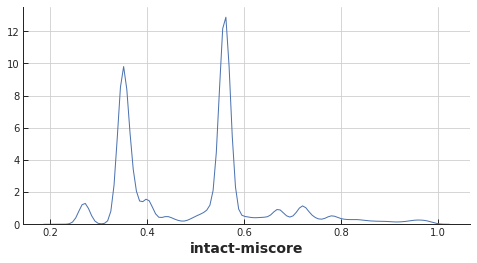

In [22]:
sns.distplot(dfIntAct1['intact-miscore'], hist=False);

---
**Interaction type**

In [23]:
dfIntAct1.groupby(by="Interaction type(s)").size().sort_values(ascending=False)

Interaction type(s)
psi-mi:"MI:0915"(physical association)                                  342550
psi-mi:"MI:0914"(association)                                           188779
psi-mi:"MI:2364"(proximity)                                              20602
psi-mi:"MI:0407"(direct interaction)                                     15139
psi-mi:"MI:0403"(colocalization)                                          3684
psi-mi:"MI:0217"(phosphorylation reaction)                                1962
psi-mi:"MI:0220"(ubiquitination reaction)                                  395
psi-mi:"MI:0203"(dephosphorylation reaction)                               362
psi-mi:"MI:0570"(protein cleavage)                                         214
psi-mi:"MI:0194"(cleavage reaction)                                        161
psi-mi:"MI:0213"(methylation reaction)                                      73
psi-mi:"MI:0557"(adp ribosylation reaction)                                 59
psi-mi:"MI:0414"(enzymatic react

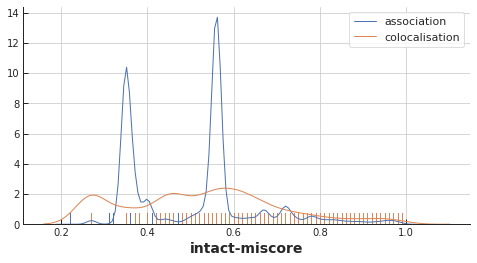

In [24]:
l1 = ['psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0914"(association)', 'psi-mi:"MI:0407"(direct interaction)']
foo = dfIntAct1.loc[dfIntAct1['Interaction type(s)'].isin(l1)]

l2 = ['psi-mi:"MI:0403"(colocalization)']
bar = dfIntAct1.loc[dfIntAct1['Interaction type(s)'].isin(l2)]

sns.distplot(foo['intact-miscore'], hist=False, rug=True, norm_hist=True, label='association')
sns.distplot(bar['intact-miscore'], hist=False, rug=True, norm_hist=True, label='colocalisation')
plt.legend();

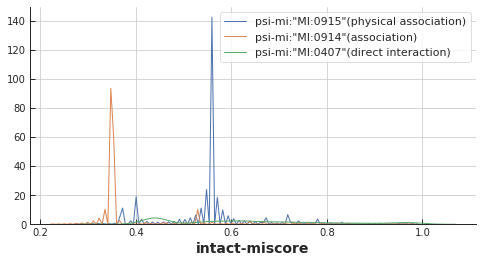

In [25]:
L = ['psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0914"(association)', 'psi-mi:"MI:0407"(direct interaction)']

for l in L:
    foo = dfIntAct1.loc[dfIntAct1['Interaction type(s)'] == l]
    sns.distplot(foo['intact-miscore'], hist=False, label=l)
plt.legend();

---
**Complex expansion method**

Here we distinguish between true binary interactions and N-ary interactions

In [26]:
dfIntAct_3["Expansion method(s)"].value_counts()

-                                    357711
psi-mi:"MI:1060"(spoke expansion)    216648
Name: Expansion method(s), dtype: int64

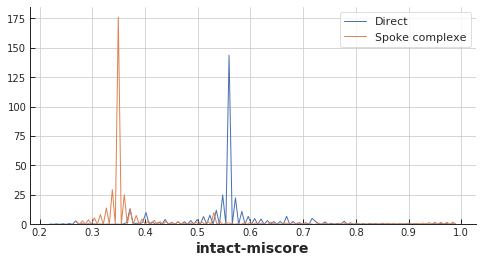

In [27]:
l1 = ['-']
foo = dfIntAct1.loc[dfIntAct1['Expansion method(s)'].isin(l1)]

l2 = ['psi-mi:"MI:1060"(spoke expansion)']
bar = dfIntAct1.loc[dfIntAct1['Expansion method(s)'].isin(l2)]

sns.distplot(foo['intact-miscore'], hist=False, kde=True, norm_hist=True, label='Direct')
sns.distplot(bar['intact-miscore'], hist=False, kde=True, norm_hist=True, label='Spoke complexe')
plt.legend();

---
**detection method**

In [28]:
dfIntAct1.groupby(by="Interaction detection method(s)").size().sort_values(ascending=False)

Interaction detection method(s)
psi-mi:"MI:0007"(anti tag coimmunoprecipitation)                                        133851
psi-mi:"MI:0397"(two hybrid array)                                                       93081
psi-mi:"MI:1356"(validated two hybrid)                                                   80163
psi-mi:"MI:1112"(two hybrid prey pooling approach)                                       67345
psi-mi:"MI:0006"(anti bait coimmunoprecipitation)                                        29788
psi-mi:"MI:0676"(tandem affinity purification)                                           25284
psi-mi:"MI:0096"(pull down)                                                              23629
psi-mi:"MI:0398"(two hybrid pooling approach)                                            22009
psi-mi:"MI:1314"(proximity-dependent biotin identification)                              18716
psi-mi:"MI:0018"(two hybrid)                                                             15642
psi-mi:"MI:0030"(c

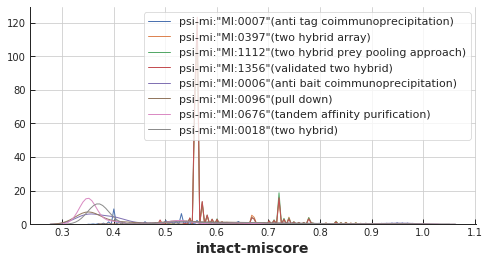

In [29]:
L = [
    'psi-mi:"MI:0007"(anti tag coimmunoprecipitation)', 
    'psi-mi:"MI:0397"(two hybrid array)', 
    'psi-mi:"MI:1112"(two hybrid prey pooling approach)',
    'psi-mi:"MI:1356"(validated two hybrid)',
    'psi-mi:"MI:0006"(anti bait coimmunoprecipitation)',
    'psi-mi:"MI:0096"(pull down)',
    'psi-mi:"MI:0676"(tandem affinity purification)',
    'psi-mi:"MI:0018"(two hybrid)'
]

for l in L:
    foo = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'] == l]
    sns.distplot(foo['intact-miscore'], hist=False, label=l)
plt.legend();

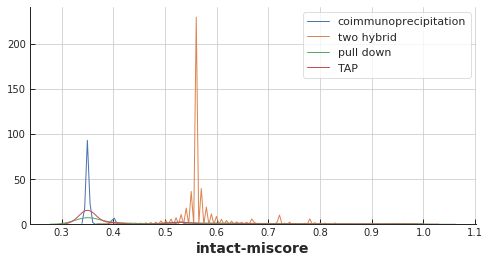

In [30]:
l1 = [
    'psi-mi:"MI:0007"(anti tag coimmunoprecipitation)',
    'psi-mi:"MI:0006"(anti bait coimmunoprecipitation)',
]
foo = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'].isin(l1)]

l2 = [
    'psi-mi:"MI:0397"(two hybrid array)', 
    'psi-mi:"MI:1112"(two hybrid prey pooling approach)',
    'psi-mi:"MI:1356"(validated two hybrid)',
    'psi-mi:"MI:0018"(two hybrid)'
]
bar = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'].isin(l2)]

l3 = ['psi-mi:"MI:0096"(pull down)',]
baar = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'].isin(l3)]

l4 = ['psi-mi:"MI:0676"(tandem affinity purification)',]
fool = dfIntAct1.loc[dfIntAct1['Interaction detection method(s)'].isin(l4)]

sns.distplot(foo['intact-miscore'], hist=False, label='coimmunoprecipitation')
sns.distplot(bar['intact-miscore'], hist=False, label='two hybrid')
sns.distplot(baar['intact-miscore'], hist=False, label='pull down')
sns.distplot(fool['intact-miscore'], hist=False, label='TAP')
plt.legend();

---
**Host organisms**

In [31]:
dfIntAct1.groupby(by="Host organism(s)").size().sort_values(ascending=False)

Host organism(s)
taxid:4932(yeasx)|taxid:4932("Saccharomyces cerevisiae (Baker's yeast)")                                                       276113
taxid:9606(human-293t)|taxid:9606(Homo sapiens 293 cells transformed with SV40 large T antigen)                                 99799
taxid:9606(human-293)|taxid:9606(Homo sapiens transformed primary embryonal kidney cells)                                       42789
taxid:-1(in vitro)|taxid:-1(In vitro)                                                                                           38990
taxid:9606(human-hela)|taxid:9606(Homo sapiens epitheloid cervix carcinoma cells)                                               31126
taxid:9606(human-293 flp-in)|taxid:9606(Homo sapiens)                                                                           10775
taxid:9606(human-u2-os)|taxid:9606(Human U2-OS osteosarcoma cell line)                                                           8621
taxid:559292(yeast)|taxid:559292(Saccharomyce

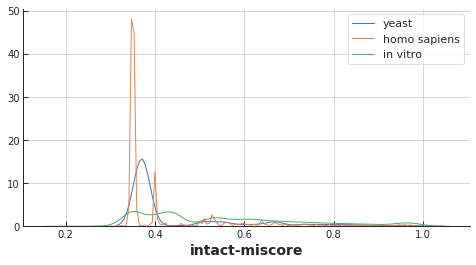

In [32]:
l1 = [
    'taxid:4932(yeasx)|taxid:4932("Saccharomyces cerevisiae (Baker\'s yeast)") ',
    'taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)'
]
foo = dfIntAct1.loc[dfIntAct1['Host organism(s)'].isin(l1)]

l2 = [
    'taxid:9606(human-293t)|taxid:9606(Homo sapiens 293 cells transformed with SV40 large T antigen)',
    'taxid:9606(human-293)|taxid:9606(Homo sapiens transformed primary embryonal kidney cells)',
    'taxid:9606(human-hela)|taxid:9606(Homo sapiens epitheloid cervix carcinoma cells)',
    'taxid:9606(human-293 flp-in)|taxid:9606(Homo sapiens)',
    'taxid:9606(human-u2-os)|taxid:9606(Human U2-OS osteosarcoma cell line)',
    'taxid:9606(human)|taxid:9606(Homo sapiens)'
]
bar = dfIntAct1.loc[dfIntAct1['Host organism(s)'].isin(l2)]

l3 = ['taxid:-1(in vitro)|taxid:-1(In vitro)']
baar = dfIntAct1.loc[dfIntAct1['Host organism(s)'].isin(l3)]

sns.distplot(foo['intact-miscore'], hist=False, label='yeast')
sns.distplot(bar['intact-miscore'], hist=False, label='homo sapiens')
sns.distplot(baar['intact-miscore'], hist=False, label='in vitro')
plt.legend();

## Filter 2: no complexes and no colocalisation

**Keep only direct interactions (no complexe expensions)**

In [33]:
dfIntAct1.shape

(574359, 49)

In [34]:
dfIntAct1_2 = dfIntAct1.loc[dfIntAct1['Expansion method(s)'] == '-']
dfIntAct1_2.shape

(357711, 49)

---
**EDA part 2**

In [35]:
dfIntAct1_2.groupby(by="Interaction type(s)").size().sort_values(ascending=False)

Interaction type(s)
psi-mi:"MI:0915"(physical association)                                  334437
psi-mi:"MI:0407"(direct interaction)                                     14576
psi-mi:"MI:0403"(colocalization)                                          3063
psi-mi:"MI:2364"(proximity)                                               1755
psi-mi:"MI:0217"(phosphorylation reaction)                                1627
psi-mi:"MI:0914"(association)                                             1201
psi-mi:"MI:0203"(dephosphorylation reaction)                               362
psi-mi:"MI:0570"(protein cleavage)                                         142
psi-mi:"MI:0194"(cleavage reaction)                                        124
psi-mi:"MI:0557"(adp ribosylation reaction)                                 57
psi-mi:"MI:0213"(methylation reaction)                                      54
psi-mi:"MI:0192"(acetylation reaction)                                      40
psi-mi:"MI:0220"(ubiquitination 

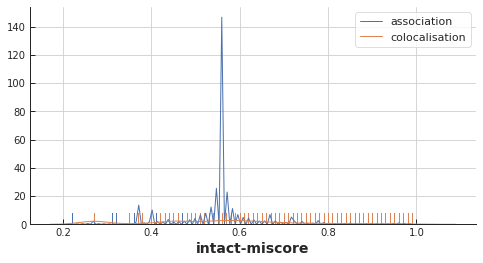

In [36]:
l1 = ['psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0914"(association)', 'psi-mi:"MI:0407"(direct interaction)']
foo = dfIntAct1_2.loc[dfIntAct1_2['Interaction type(s)'].isin(l1)]

l2 = ['psi-mi:"MI:0403"(colocalization)']
bar = dfIntAct1_2.loc[dfIntAct1_2['Interaction type(s)'].isin(l2)]

sns.distplot(foo['intact-miscore'], hist=False, rug=True, norm_hist=True, label='association')
sns.distplot(bar['intact-miscore'], hist=False, rug=True, norm_hist=True, label='colocalisation')
plt.legend();

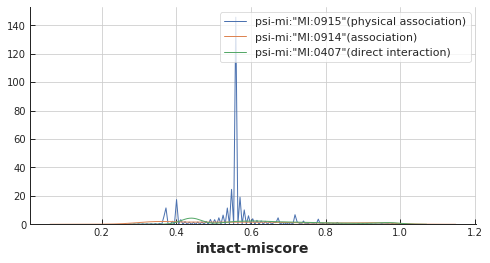

In [37]:
L = ['psi-mi:"MI:0915"(physical association)', 'psi-mi:"MI:0914"(association)', 'psi-mi:"MI:0407"(direct interaction)']

for l in L:
    foo = dfIntAct1_2.loc[dfIntAct1_2['Interaction type(s)'] == l]
    sns.distplot(foo['intact-miscore'], hist=False, label=l)
plt.legend();

---
**keep only associations, no colocalisations or other things**

In [38]:
foo = [
    'psi-mi:"MI:0915"(physical association)', 
    'psi-mi:"MI:0914"(association)', 
    'psi-mi:"MI:0407"(direct interaction)'
]

dfIntAct1_3 = dfIntAct1_2.loc[dfIntAct1_2['Interaction type(s)'].isin(foo)]
dfIntAct1_3.shape

(350214, 49)

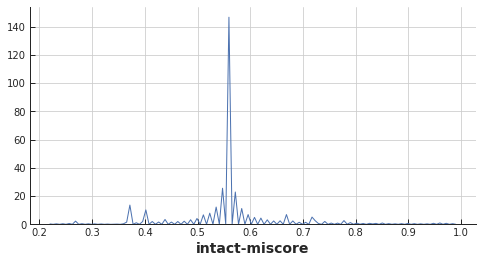

In [39]:
sns.distplot(dfIntAct1_3['intact-miscore'], kde=True,hist=False);

---
**Reinitialise index**

In [40]:
dfIntAct2 = dfIntAct1_3.reset_index(drop=True)
glance(dfIntAct2)

DataFrame: 350,214 rows 	 49 columns


,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Stoichiometry(s) interactor B,Identification method participant A,Identification method participant B,All IDs interactor A,All IDs interactor B,uniprotkb_IDs_A,uniprotkb_IDs_B,first_uniprotkb_IDs_A,first_uniprotkb_IDs_B,intact-miscore
0,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0078""(nucleotide sequence identific...","psi-mi:""MI:0078""(nucleotide sequence identific...",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56
1,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56
2,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56
3,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56
4,uniprotkb:Q99961,uniprotkb:O43426,intact:EBI-697911|uniprotkb:Q99668|uniprotkb:B...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:sh3g1_human(display_long)|uniprotkb:End...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,-,"psi-mi:""MI:0411""(enzyme linked immunosorbent a...","psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:Q99961|intact:EBI-697911|uniprotkb:Q...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,Q99961|Q99668|B4DRA1|E7EVZ4|M0QZV5,O43426|O43425|O94984|Q4KMR1,Q99961,O43426,0.44


# UniProt mapping

In [41]:
intactFinal = dfIntAct2

---
**Download matching from UniProt**

In [42]:
uniprotkbIdsList = list(set(list(intactFinal.first_uniprotkb_IDs_A)+list(intactFinal.first_uniprotkb_IDs_B)))
print(len(uniprotkbIdsList))

16909


In [43]:
# Sanity checks
assert ~('' in uniprotkbIdsList)

In [44]:
uniprotMapping = mappingUniprotIDs(fromID = 'ACC', listIDs = uniprotkbIdsList)
uniprotMapping

,From,To
0,V9HW31,V9HW31
1,O76075,O76075
2,Q6P499,Q6P499
3,F2Z2M7,F2Z2M7
4,P55082,P55082
5,Q6ZQS4,Q6ZQS4
6,P01241,P01241
7,Q16512,Q16512
8,P08912,P08912
9,P25391,P25391


---
**Drop proteins matching several uniprot ids**

In [45]:
uniprotMapping_2 = uniprotMapping.drop_duplicates(subset='From',keep=False).reset_index(drop=True)
glance(uniprotMapping_2)

DataFrame: 16,897 rows 	 2 columns


,From,To
0,V9HW31,V9HW31
1,O76075,O76075
2,Q6P499,Q6P499
3,F2Z2M7,F2Z2M7
4,P55082,P55082


---
**Compare to UniProt reference list**

To eliminate unreviewed proteins for example

In [46]:
uniprotIDs = pd.read_csv(
    os.path.join(cfg['rawDataUniProt'], 
                 "uniprot_allProteins_Human_v{}.pkl".format(logVersions['UniProt']['rawData'])),
    header=None,
    names=['To']
)
glance(uniprotIDs)

DataFrame: 20,386 rows 	 1 columns


,To
0,A0A024RBG1
1,A0A075B6H7
2,A0A075B6H8
3,A0A075B6H9
4,A0A075B6I0


In [47]:
uniprotMapping_3 = uniprotMapping_2.merge(
    uniprotIDs,
    how='inner',
    on='To'
)
glance(uniprotMapping_3)

DataFrame: 15,600 rows 	 2 columns


,From,To
0,O76075,O76075
1,Q6P499,Q6P499
2,P55082,P55082
3,P01241,P01241
4,Q16512,Q16512


In [48]:
print("{:,}/{:,} couldn't be matched".format(len(uniprotkbIdsList)-len(set(uniprotMapping.From)), len(uniprotkbIdsList)))
print('Droped duplicates: {:,}'.format(len(uniprotMapping) - len(uniprotMapping_2)))
print('Droped "unofficials": {:,}'.format(len(uniprotMapping_2) - len(uniprotMapping_3)))

0/16,909 couldn't be matched
Droped duplicates: 28
Droped "unofficials": 1,297


In [49]:
# Sanity checks
assert len(uniprotMapping_2.loc[uniprotMapping_2.duplicated(keep=False)]) == 0
assert len(uniprotMapping_2.From) == len(set(uniprotMapping_2.From))

---
**Match to primary identifiers**

In [50]:
uniprotMapping_A = uniprotMapping_3.copy()
uniprotMapping_A = uniprotMapping_A.rename(columns={
    'From': 'first_uniprotkb_IDs_A', 
    'To': 'uniprotID_A'
})
glance(uniprotMapping_A)

uniprotMapping_B = uniprotMapping_3.copy()
uniprotMapping_B = uniprotMapping_B.rename(columns={
    'From': 'first_uniprotkb_IDs_B', 
    'To': 'uniprotID_B'
})
glance(uniprotMapping_B)

DataFrame: 15,600 rows 	 2 columns


,first_uniprotkb_IDs_A,uniprotID_A
0,O76075,O76075
1,Q6P499,Q6P499
2,P55082,P55082
3,P01241,P01241
4,Q16512,Q16512


DataFrame: 15,600 rows 	 2 columns


,first_uniprotkb_IDs_B,uniprotID_B
0,O76075,O76075
1,Q6P499,Q6P499
2,P55082,P55082
3,P01241,P01241
4,Q16512,Q16512


In [51]:
intactFinal_2 = intactFinal.merge(
    uniprotMapping_A,
    how="inner", 
    on="first_uniprotkb_IDs_A"
).merge(
    uniprotMapping_B,
    how="inner", 
    on="first_uniprotkb_IDs_B"
)

glance(intactFinal_2)

DataFrame: 329,409 rows 	 51 columns


,#ID(s) interactor A,ID(s) interactor B,Alt. ID(s) interactor A,Alt. ID(s) interactor B,Alias(es) interactor A,Alias(es) interactor B,Interaction detection method(s),Publication 1st author(s),Publication Identifier(s),Taxid interactor A,...,Identification method participant B,All IDs interactor A,All IDs interactor B,uniprotkb_IDs_A,uniprotkb_IDs_B,first_uniprotkb_IDs_A,first_uniprotkb_IDs_B,intact-miscore,uniprotID_A,uniprotID_B
0,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0084""(phage display)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,"psi-mi:""MI:0078""(nucleotide sequence identific...",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56,P49418,O43426
1,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,"psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56,P49418,O43426
2,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,"psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56,P49418,O43426
3,uniprotkb:P49418,uniprotkb:O43426,intact:EBI-7121510|uniprotkb:Q75MK5|uniprotkb:...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:amph_human(display_long)|uniprotkb:AMPH...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,"psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:P49418|intact:EBI-7121510|uniprotkb:...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,P49418|Q75MK5|Q75MM3|A4D1X9|O43538|A4D1X8|Q75M...,O43426|O43425|O94984|Q4KMR1,P49418,O43426,0.56,P49418,O43426
4,uniprotkb:Q99961,uniprotkb:O43426,intact:EBI-697911|uniprotkb:Q99668|uniprotkb:B...,intact:EBI-2821539|uniprotkb:O43425|uniprotkb:...,psi-mi:sh3g1_human(display_long)|uniprotkb:End...,psi-mi:synj1_human(display_long)|uniprotkb:SYN...,"psi-mi:""MI:0081""(peptide array)",Cestra et al. (1999),pubmed:10542231|mint:MINT-5211933,taxid:9606(human)|taxid:9606(Homo sapiens),...,"psi-mi:""MI:0083""(peptide synthesis)",uniprotkb:Q99961|intact:EBI-697911|uniprotkb:Q...,uniprotkb:O43426|intact:EBI-2821539|uniprotkb:...,Q99961|Q99668|B4DRA1|E7EVZ4|M0QZV5,O43426|O43425|O94984|Q4KMR1,Q99961,O43426,0.44,Q99961,O43426


In [52]:
print('{:,} interactions removed'.format(len(intactFinal) - len(intactFinal_2)))

20,805 interactions removed


In [53]:
# Sanity check
assert len(intactFinal_2) < len(intactFinal)
assert intactFinal_2.uniprotID_A.isna().sum() == 0
assert intactFinal_2.uniprotID_B.isna().sum() == 0

---
**Some sanity checks before removing some columns**

In [54]:
# human-human only
assert set(list(intactFinal_2['Taxid interactor A'].unique())+list(intactFinal_2['Taxid interactor B'].unique())) == set(['taxid:9606(human)|taxid:9606(Homo sapiens)'])

# PPIs only
assert set(list(intactFinal_2['Type(s) interactor A'].unique())+list(intactFinal_2['Type(s) interactor B'].unique())) == set(['psi-mi:"MI:0326"(protein)'])

# no spoke expansions
assert list(intactFinal_2['Expansion method(s)'].unique()) == ['-']

---
**Filter columns and order uniprotIDs alphabetically**



In [55]:
intactFinal_3 = intactFinal_2[[
    'uniprotID_A', 
    'uniprotID_B',
    'intact-miscore',
    'Interaction detection method(s)',
    'Publication Identifier(s)',
    'Interaction type(s)',
    'Host organism(s)'
]].copy()
glance(intactFinal_3)

DataFrame: 329,409 rows 	 7 columns


,uniprotID_A,uniprotID_B,intact-miscore,Interaction detection method(s),Publication Identifier(s),Interaction type(s),Host organism(s)
0,P49418,O43426,0.56,"psi-mi:""MI:0084""(phage display)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
1,P49418,O43426,0.56,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
2,P49418,O43426,0.56,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
3,P49418,O43426,0.56,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
4,Q99961,O43426,0.44,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)


In [56]:
uniprotABids = intactFinal_3.loc[:,["uniprotID_A","uniprotID_B"]].values.tolist()

for i in range(len(uniprotABids)):
    uniprotABids[i].sort()
    
uniprotA, uniprotB = map(list, zip(*uniprotABids))

intactFinal_3.loc[:,'uniprotID_A'] = uniprotA
intactFinal_3.loc[:,'uniprotID_B'] = uniprotB

glance(intactFinal_3)

DataFrame: 329,409 rows 	 7 columns


,uniprotID_A,uniprotID_B,intact-miscore,Interaction detection method(s),Publication Identifier(s),Interaction type(s),Host organism(s)
0,O43426,P49418,0.56,"psi-mi:""MI:0084""(phage display)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
1,O43426,P49418,0.56,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
2,O43426,P49418,0.56,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
3,O43426,P49418,0.56,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
4,O43426,Q99961,0.44,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)


In [57]:
# Sanity check
foo = intactFinal_3.uniprotID_A <= intactFinal_3.uniprotID_B
assert len(foo.loc[~foo]) == 0

# Group by PPI

In [58]:
dfIntActPreGr = intactFinal_3
glance(dfIntActPreGr)

DataFrame: 329,409 rows 	 7 columns


,uniprotID_A,uniprotID_B,intact-miscore,Interaction detection method(s),Publication Identifier(s),Interaction type(s),Host organism(s)
0,O43426,P49418,0.56,"psi-mi:""MI:0084""(phage display)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
1,O43426,P49418,0.56,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
2,O43426,P49418,0.56,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
3,O43426,P49418,0.56,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)
4,O43426,Q99961,0.44,"psi-mi:""MI:0081""(peptide array)",pubmed:10542231|mint:MINT-5211933,"psi-mi:""MI:0407""(direct interaction)",taxid:-1(in vitro)|taxid:-1(In vitro)


---
**Remove self interactions**

In [59]:
foo = dfIntActPreGr.loc[dfIntActPreGr.uniprotID_A == dfIntActPreGr.uniprotID_B]
print("{:,} self interactions (/{:,})".format(len(foo),len(dfIntActPreGr)))

6,786 self interactions (/329,409)


In [60]:
dfIntActPreGr_2 = dfIntActPreGr.loc[dfIntActPreGr.uniprotID_A != dfIntActPreGr.uniprotID_B]
dfIntActPreGr_2.shape

(322623, 7)

---
**EDA on duplicated interactions**

In [61]:
foo = dfIntActPreGr_2.groupby(by=['uniprotID_A', 'uniprotID_B']).size()

print('Number of unique interactions: {:,}/{:,}'.format(len(foo), foo.sum()))

Number of unique interactions: 128,790/322,623


*Number of duplicates*

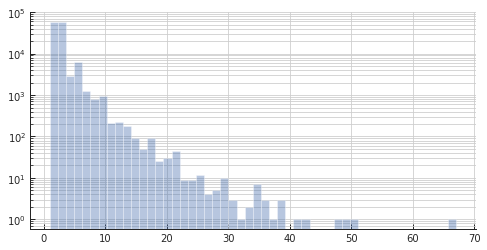

In [62]:
ax = sns.distplot(foo, kde=False,hist=True, norm_hist=False)
ax.set_yscale('log');

*Differences amongst duplicates*

In [63]:
foo = dfIntActPreGr_2.groupby(by=['uniprotID_A', 'uniprotID_B']).agg(lambda x: len(set(x)) == 1)

In [64]:
print("Number of interactions with discrepancies (/{:,})".format(len(foo)))
for col in foo.columns:
    print("\t{}: {:,}".format(col,len(foo.loc[~foo[col]])))

Number of interactions with discrepancies (/128,790)
	intact-miscore: 2,415
	Interaction detection method(s): 73,340
	Publication Identifier(s): 10,902
	Interaction type(s): 2,687
	Host organism(s): 7,994


---
**Only keep interactions with the highest MI-score**

In [65]:
dfIntActPreGr_3 = dfIntActPreGr_2.sort_values('intact-miscore').drop_duplicates(subset=['uniprotID_A', 'uniprotID_B'], keep='last')

In [66]:
# Sanity check
foo = dfIntActPreGr_2.groupby(by=['uniprotID_A', 'uniprotID_B']).size()
assert len(dfIntActPreGr_3) == len(foo)

# Final sanity checks

In [67]:
THEintact = dfIntActPreGr_3

In [68]:
# no missing MI-score
assert THEintact['intact-miscore'].isna().sum() == 0

# only associations (no colocalisations)
foo = [
    'psi-mi:"MI:0915"(physical association)', 
    'psi-mi:"MI:0914"(association)', 
    'psi-mi:"MI:0407"(direct interaction)'
]
assert set(THEintact['Interaction type(s)']).issubset(foo)

# No missing IDs
for i in ['uniprotID_A','uniprotID_B']:
    assert THEintact[i].isna().sum() == 0
    assert len(THEintact.loc[THEintact[i] == '']) == 0
    
# No self interactions
foo = THEintact.loc[THEintact.uniprotID_A == THEintact.uniprotID_B]
assert len(foo) == 0

# alphabetical order
foo = THEintact.loc[THEintact.uniprotID_A > THEintact.uniprotID_B]
assert len(foo) == 0

# Final EDA

In [79]:
print(f"Number of interactions: {THEintact.shape[0]:,}")
foo = set(pd.concat([THEintact.uniprotID_A,THEintact.uniprotID_B]))
print(f"Covering {len(foo):,} proteins")

Number of interactions: 128,790
Covering 15,506 proteins


*Confidence score*

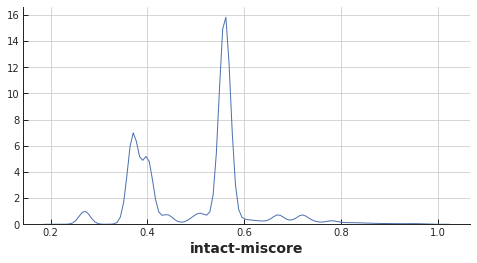

In [80]:
sns.distplot(THEintact['intact-miscore'], hist=False);

*Interaction types*

In [81]:
THEintact.groupby(by="Interaction type(s)").size().sort_values(ascending=False)

Interaction type(s)
psi-mi:"MI:0915"(physical association)    123639
psi-mi:"MI:0407"(direct interaction)        4647
psi-mi:"MI:0914"(association)                504
dtype: int64

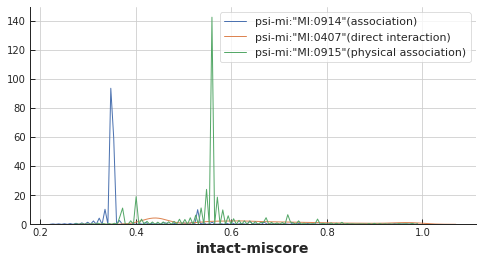

In [82]:
for l in set(THEintact["Interaction type(s)"]):
    foo = dfIntAct1.loc[dfIntAct1['Interaction type(s)'] == l]
    sns.distplot(foo['intact-miscore'], hist=False, label=l)
plt.legend();

*Detection methods*

In [83]:
THEintact.groupby(by="Interaction detection method(s)").size().sort_values(ascending=False)

Interaction detection method(s)
psi-mi:"MI:1356"(validated two hybrid)                                      38869
psi-mi:"MI:0397"(two hybrid array)                                          21545
psi-mi:"MI:0018"(two hybrid)                                                10503
psi-mi:"MI:1112"(two hybrid prey pooling approach)                           9573
psi-mi:"MI:0006"(anti bait coimmunoprecipitation)                            8182
psi-mi:"MI:0398"(two hybrid pooling approach)                                7039
psi-mi:"MI:0030"(cross-linking study)                                        4885
psi-mi:"MI:2222"(inference by socio-affinity scoring)                        4769
psi-mi:"MI:0007"(anti tag coimmunoprecipitation)                             4456
psi-mi:"MI:0096"(pull down)                                                  3399
psi-mi:"MI:0399"(two hybrid fragment pooling approach)                       2297
psi-mi:"MI:0112"(ubiquitin reconstruction)                        

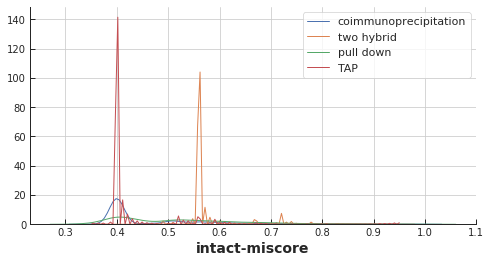

In [84]:
l1 = [
    'psi-mi:"MI:0007"(anti tag coimmunoprecipitation)',
    'psi-mi:"MI:0006"(anti bait coimmunoprecipitation)',
]
foo = THEintact.loc[THEintact['Interaction detection method(s)'].isin(l1)]

l2 = [
    'psi-mi:"MI:0397"(two hybrid array)', 
    'psi-mi:"MI:1112"(two hybrid prey pooling approach)',
    'psi-mi:"MI:1356"(validated two hybrid)',
    'psi-mi:"MI:0018"(two hybrid)'
]
bar = THEintact.loc[THEintact['Interaction detection method(s)'].isin(l2)]

l3 = ['psi-mi:"MI:0096"(pull down)',]
baar = THEintact.loc[THEintact['Interaction detection method(s)'].isin(l3)]

l4 = ['psi-mi:"MI:0676"(tandem affinity purification)',]
fool = THEintact.loc[THEintact['Interaction detection method(s)'].isin(l4)]

sns.distplot(foo['intact-miscore'], hist=False, label='coimmunoprecipitation')
sns.distplot(bar['intact-miscore'], hist=False, label='two hybrid')
sns.distplot(baar['intact-miscore'], hist=False, label='pull down')
sns.distplot(fool['intact-miscore'], hist=False, label='TAP')
plt.legend();

# Select interactions based on confidence score

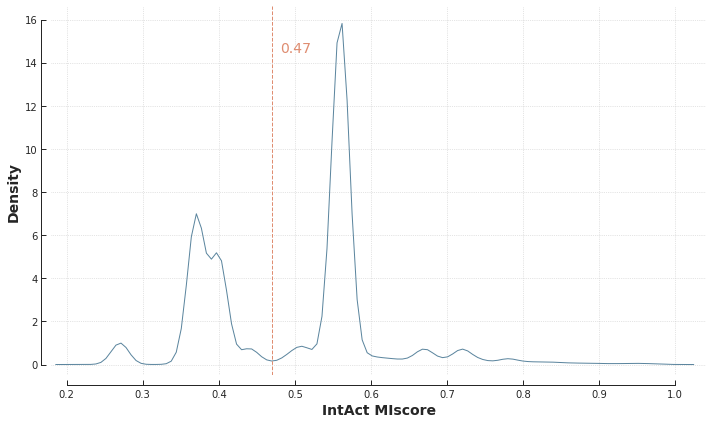

In [105]:
exportIt = False

threshold = 0.47

fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(
    THEintact['intact-miscore'], 
    hist=False, norm_hist=True, 
    color=palette_redon[0],
    ax=ax,
)

ax.set_ylabel('Density')
ax.set_xlabel('IntAct MIscore')

color_annotation = palette_redon[4]
plt.axvline(threshold, color=color_annotation,linestyle='--', lw=1)
plt.text(threshold+0.01, 14.5, '{}'.format(threshold), color=color_annotation, size=14)

ax.set_xlim(left=.18,right=1.04)
ax.set_ylim(bottom=-.5)

ax.spines['left'].set_position(("outward", 10))
ax.spines['bottom'].set_position(("outward", 10))
ax.spines['left'].set_bounds(0, 16)
ax.spines['bottom'].set_bounds(0.2, 1.)
ax.grid(which='major', linewidth=.7, linestyle=':')

plt.tight_layout()

if exportIt:
    export_figure(fig, f"intactMIscore_withThreshold_1")

In [107]:
foo = THEintact.loc[THEintact['intact-miscore'] >= threshold]
print('A threshold of {} means keeping {:,} interactions out of {:,}'.format(threshold, len(foo), len(THEintact)))
bar = set(pd.concat([foo.uniprotID_A,foo.uniprotID_B]))
print(f"Covering {len(bar):,} proteins")

A threshold of 0.47 means keeping 78,230 interactions out of 128,790
Covering 12,026 proteins


In [77]:
THEintact_2 = THEintact.loc[THEintact['intact-miscore'] >= threshold]
glance(THEintact_2)

DataFrame: 78,229 rows 	 7 columns


,uniprotID_A,uniprotID_B,intact-miscore,Interaction detection method(s),Publication Identifier(s),Interaction type(s),Host organism(s)
267687,P28223,P41595,0.47,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",pubmed:28258217|imex:IM-26980,"psi-mi:""MI:0915""(physical association)",taxid:9534(chlae-cos_7)|taxid:9534(Cercopithec...
123005,O00161,P56962,0.47,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",imex:IM-27238|pubmed:29549094,"psi-mi:""MI:0915""(physical association)",taxid:9606(human-hela)|taxid:9606(Homo sapiens...
226101,P82979,Q01081,0.47,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",pubmed:18559666|imex:IM-26479,"psi-mi:""MI:0915""(physical association)",taxid:9606(human-293t)|taxid:9606(Homo sapiens...
227471,O60678,Q14524,0.47,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",pubmed:23912080|imex:IM-22140,"psi-mi:""MI:0915""(physical association)",taxid:9606(human-hek-10)|taxid:9606(Homo sapiens)
39294,P10275,Q15648,0.47,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",imex:IM-28915|pubmed:33640491,"psi-mi:""MI:0915""(physical association)",taxid:9606(human-293t)|taxid:9606(Homo sapiens...


# Export


- v2.1 used IntAct v20211015 and a threshold at 0.47

In [78]:
intact_export = THEintact_2.copy()

intact_export = intact_export[[
    'uniprotID_A',
    'uniprotID_B',
    'intact-miscore'
]].reset_index(drop=True)

glance(intact_export)

DataFrame: 78,229 rows 	 3 columns


,uniprotID_A,uniprotID_B,intact-miscore
0,P28223,P41595,0.47
1,O00161,P56962,0.47
2,P82979,Q01081,0.47
3,O60678,Q14524,0.47
4,P10275,Q15648,0.47


In [80]:
versionINTACTfiltered = '2-1'

# logVersions['IntAct']['preprocessed'] = dict()
logVersions['IntAct']['preprocessed']['filtered'] = versionINTACTfiltered

dump_LogVersions(logVersions)

In [81]:
intact_export.to_pickle(os.path.join(cfg['outputPreprocessingIntAct'], 
                                     "intact_filteredScore_v{}.pkl".format(versionINTACTfiltered)))


## Create an index of the number of interactions per protein

Based on the unfiltered dataset

In [86]:
intact_export = pd.read_pickle(
    os.path.join(cfg['outputPreprocessingIntAct'], 
                 "intact_allScores_v{}.pkl".format(logVersions['IntAct']['preprocessed']['all']))
)
glance(intact_export)

DataFrame: 128,790 rows 	 3 columns


,uniprotID_A,uniprotID_B,intact-miscore
0,P14625,P68400,0.22
1,O14936,Q9Y624,0.22
2,P05556,Q9Y6C2,0.22
3,P04049,P05787,0.22
4,Q12929,Q92738,0.22


In [87]:
allIDs_all = pd.concat([intact_export.uniprotID_A,intact_export.uniprotID_B])

In [88]:
Ninter_perProtein = allIDs_all.value_counts().to_dict()
glance(Ninter_perProtein)


-- P42858: <class 'int'>
850

-- Q9NRI5: <class 'int'>
642

-- A8MQ03: <class 'int'>
487

-- P05067: <class 'int'>
486

-- P62993: <class 'int'>
477


**Export**

In [89]:
path0 = os.path.join(
    cfg['outputPreprocessingIntAct'], 
    "Ninter_perProtein_intact_allScores_v{}.pkl".format(logVersions['IntAct']['preprocessed']['all'])
)

with open(path0, 'wb') as f:
    pkl.dump(Ninter_perProtein, f, protocol=pkl.HIGHEST_PROTOCOL)

## Create "official" list of hubs

Based on the literature, definition of top 20% in the unfiltered (but cleaned) dataset

In [90]:
foo = allIDs_all.value_counts()

print(foo.describe(percentiles = [0.8]))

print(f"")

count    15508.000000
mean        16.609492
std         32.518175
min          1.000000
50%          6.000000
80%         21.000000
max        850.000000
dtype: float64



**Which happens to mean >= 21 interactions**

In [92]:
top20p = list(foo.loc[foo >= 21].index)
glance(top20p)

len: 3240
['P42858', 'Q9NRI5', 'A8MQ03', 'P05067', 'P62993']


**Export**

In [93]:
path0 = os.path.join(
    cfg['outputPreprocessingIntAct'], 
    "listHubs_20p_v{}.pkl".format(logVersions['IntAct']['preprocessed']['all'])
)

with open(path0, 'wb') as f:
    pkl.dump(top20p, f, protocol=pkl.HIGHEST_PROTOCOL)

In [94]:
path0

'/rds/user/ll582/hpc-work/PPIdata/output/1_preprocessing/IntAct/listHubs_20p_v2-1.pkl'